# Argentina programa 4.0 - Módulo 3: Aprendizaje Automático
---
# Ejercicios semana 8 - Autoencoders


## Fashion-MINST


Al igual que la semana anterior, usen el conjunto de datos fashion-MINST. trayendo el el dataset desde `keras.datasets.fashion_mnist`:

1.   Separen en train y test, normalicen, etcetc (hecho...)
2.   Con el notebook de la clase de base hagan un autoencoder convolucional para estos datos y entrénenlo.
3.   Predigan en test y Ploteen estas *predicciones* contra su versión original. ¿Se pierde alguna característica de las imágenes? ¿Cuáles?

## Jugando en el espacio latente
1.   Usen el encoder entrenado y generen el espacio latente del conjunto de test
2.   Visualicen las imágenes de entrada junto a su representación en el espacio latente (elijan alguna dimensión que les guste, las representaciones en el espacio latente no tienen porque tener un sentido visual)
3.   Agarren alguna imagen que les guste del conjunto de test, tomen su representación latente y cambienle un par de valores (sumándole 1 o 2 por ejemplo), pasenla por el decoder y vean la imagen que genera. Prueben varios valores a ver que sale, jueguen a ser diseñadores de ropa.
4.   Generen 10 vectores al azar del espacio latente, pasenlos por el decoder y grafiquen a ver que sale. ¿Alguna parece ropa? No es tan fácil ser diseñadores así...

## Anomalias
1.   Bajen MNIST y, aprovechando que tienen las mismas dimensiones, pasen algunos números por el autoencoder entrenado y grafiquen las reconstrucciones. ¿Tienen sentido?
2.   Calculen el error de reproducción de un elemento de test de Fashion MNIST y el error de reproducción de un número de MNIST, también podrian probar editar alguna imagen de ropa, pasarla por el autoencoder y comparar este error con el original

In [1]:
import tensorflow as tf
from tensorflow import keras

#traemos test y train
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

#60k en train 10k en test
X_train_full = X_train_full.reshape((60000, 28, 28, 1))
X_test = X_test.reshape((10000, 28, 28, 1))

#separamos train en validación, a mano
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

X_valid = X_valid/255.0
X_train = X_train/255.0
X_test = X_test/255.0



4422102/4422102 [==============================] - 0s 0us/step


In [4]:
from keras import layers, models

# Definir el codificador convolucional
conv_encoder = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same')
])
# Definir el decodificador convolucional
conv_decoder = models.Sequential([
    layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
])

#lo defino así para que me sea más facil usar las partes
conv_autoencoder = models.Sequential([conv_encoder, conv_decoder])

conv_autoencoder.compile(optimizer='adam', loss='mean_squared_error')

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

hist = conv_autoencoder.fit(X_train, X_train,
                            epochs=100,
                            batch_size=32,
                            shuffle=True,
                            validation_data=(X_test, X_test),
                            callbacks=[early_stopping_cb]
                            )


Epoch 1/100
1719/1719 [==============================] - 15s 7ms/step - loss: 0.0256 - val_loss: 0.0182
Epoch 2/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0171 - val_loss: 0.0164
Epoch 3/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0156 - val_loss: 0.0151
Epoch 4/100
1719/1719 [==============================] - 11s 7ms/step - loss: 0.0148 - val_loss: 0.0147
Epoch 5/100
1719/1719 [==============================] - 11s 7ms/step - loss: 0.0143 - val_loss: 0.0140
Epoch 6/100
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0139 - val_loss: 0.0137
Epoch 7/100
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 8/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 9/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 10/100
1719/1719 [==============================] - 11s 7m

In [5]:
#lo salvé porque estaba harto que después se me desconecte el entorno y perder todo
conv_encoder.save('conv_encoder.h5')
conv_decoder.save('conv_decoder.h5')
conv_autoencoder.save('conv_autoencoder.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
from tensorflow.keras.models import load_model

conv_encoder = load_model('conv_encoder.h5')
conv_decoder = load_model('conv_decoder.h5')
conv_autoencoder = load_model('conv_autoencoder.h5')

Usemos el conjunto de test y veamos las salidas

313/313 [==============================] - 1s 2ms/step
Original


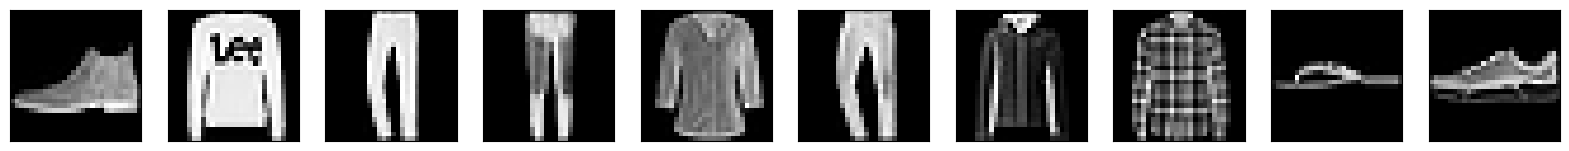

Reconstruido


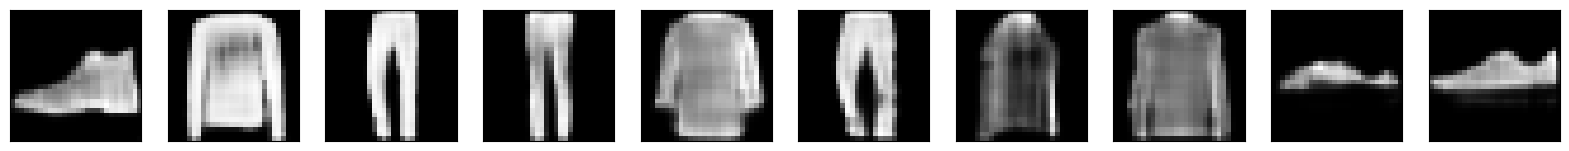

In [76]:
import matplotlib.pyplot as plt

x_test_pred_FASHION = conv_autoencoder.predict(X_test)

n = 10

print("Original")
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Reconstruido")
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_pred_FASHION[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Se pierden algunos detalles específicos de la ropa, las lineas de la camisa, la marca del buzo. Pero la forma general de cada prenda es bastante clara. Generamos los espacios latentes y los graficamos

313/313 [==============================] - 1s 2ms/step
Original


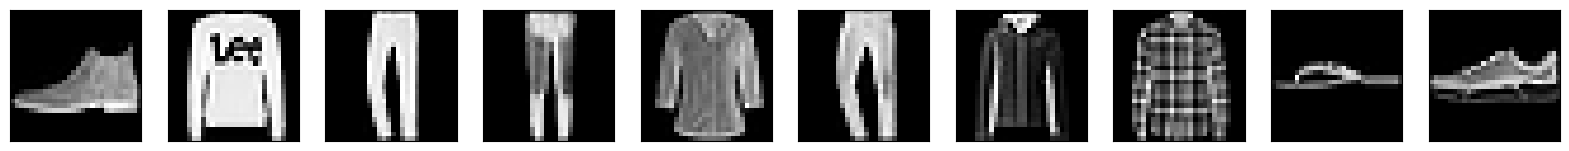

Reconstruido


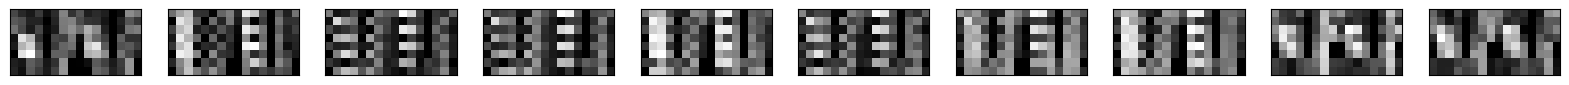

In [115]:
x_test_latente = conv_encoder.predict(X_test)
n = 10

print("Original")
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Reconstruido")
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_latente[i].reshape(8,16))  #elijo una forma cualquiera, no importa, no tiene sentido visual esto
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()



Me gusta el buzo de lee, me lo quedo

In [116]:
buzo_latente = x_test_latente[1]
buzo_latente

array([[[1.2710006 , 1.8777542 , 2.1804137 , 0.5738855 , 0.5512767 ,
         0.05477252, 1.1638663 , 1.459727  ],
        [0.44492108, 2.6779814 , 2.265723  , 0.8602257 , 0.        ,
         1.0619959 , 0.37525085, 1.3263526 ],
        [0.        , 2.624394  , 2.2824352 , 1.0215427 , 0.        ,
         1.251896  , 0.43069193, 1.3745383 ],
        [0.27825847, 1.2702694 , 0.0199106 , 0.7079991 , 0.        ,
         1.3317163 , 0.55644864, 0.57893676]],

       [[0.7435829 , 2.116752  , 2.4448097 , 0.32038653, 0.5875979 ,
         0.32546914, 0.9654733 , 0.5549703 ],
        [0.08555676, 2.7005394 , 2.1774454 , 1.3689153 , 0.        ,
         1.0888678 , 0.37519282, 0.7334188 ],
        [0.27485877, 2.704392  , 2.0537517 , 1.1988001 , 0.        ,
         1.2174302 , 0.22147429, 0.6223519 ],
        [0.03617188, 1.6349871 , 0.1100322 , 1.2446163 , 0.        ,
         1.3983291 , 0.42245582, 0.4654511 ]],

       [[0.5956876 , 2.1512225 , 2.5923848 , 0.13634524, 0.4901476 ,
       

In [117]:
buzo_latente.shape

(4, 4, 8)

Estuve probando cambiarle algunos valores y lo paso por el decoder, tengo un lindo buzo chueco, no será práctico pero todavia parece un buzo...

In [118]:
nuevo_buzo_latente = buzo_latente
nuevo_buzo_latente[0][0][0] += 3
nuevo_buzo_latente[1][0][0] += 2

1/1 [==============================] - 0s 18ms/step


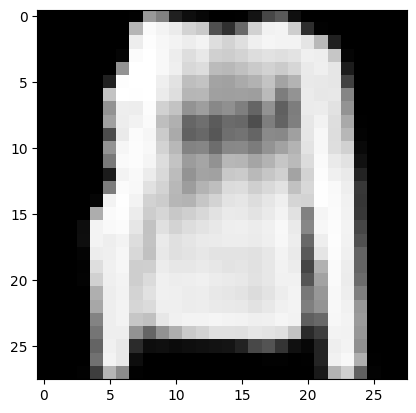

In [119]:
decoded_nuevo_buzo_latente = conv_decoder.predict(nuevo_buzo_latente.reshape(1,4,4,8)) #ver tema del shape...
plt.imshow(decoded_nuevo_buzo_latente.reshape(28, 28))
plt.show()

Para jugar, le sumo un valor al azar a todos los elementos de la representación  latente del buzo

1/1 [==============================] - 0s 22ms/step


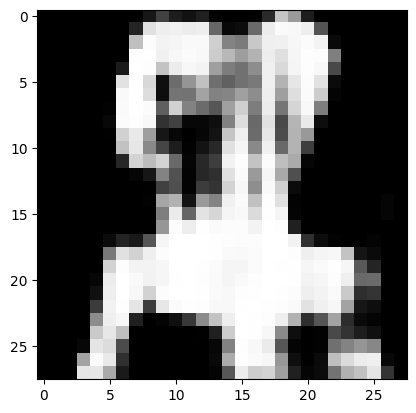

In [120]:
import numpy as np
buzo_random = buzo_latente +np.random.rand(4, 4, 8)

gen_buzo = conv_decoder.predict(buzo_random.reshape((1, 4,4,8)))
plt.imshow(gen_buzo.reshape(28,28))
plt.show()

Muy mutante, pero algo de forma tiene :P, veamos que pasa si usamos vectores totalmente al azar

1/1 [==============================] - 0s 31ms/step
Reconstruido


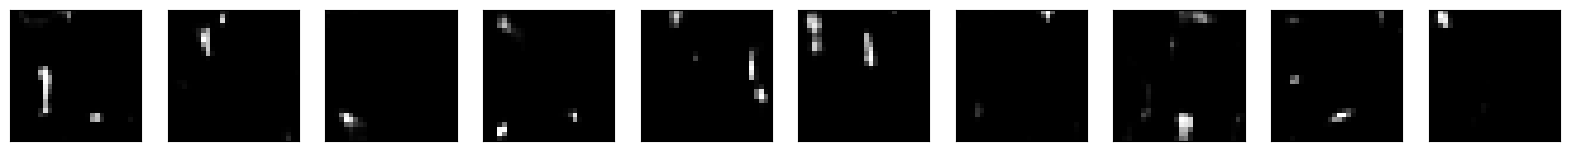

In [121]:
import numpy as np

#generemos 10 elementos del espacio latente al azar
cod_random = np.random.rand(10, 4, 4, 8)
generados = conv_decoder.predict(cod_random)

print("Reconstruido")
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(generados[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Acá ya nada tiene sentido, son cosas que viven en espacio latente que no vienen de ninguna prenda posible.

Veamos que pasa cuando le paso al autoencoder entrenado una imagen de MNIST

In [89]:
(x_train_MNIST, y_train_MNIST), (x_test_MNIST, y_test_MNIST) = keras.datasets.mnist.load_data()
#normalize to [0,1]
x_train_MNIST = x_train_MNIST.astype('float32') / 255.
x_test_MNIST = x_test_MNIST.astype('float32') / 255.

x_test_MNIST.shape

(10000, 28, 28)

313/313 [==============================] - 1s 2ms/step
Original


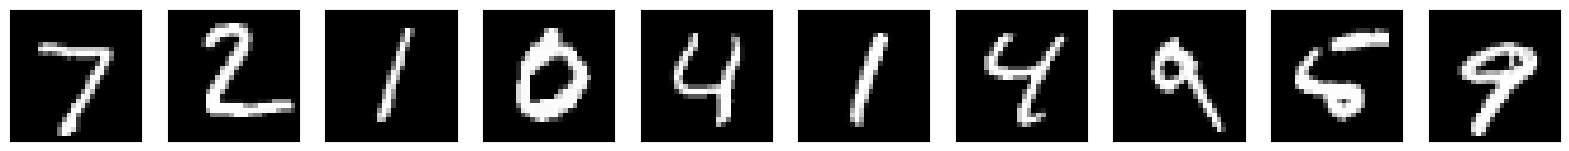

Reconstruido


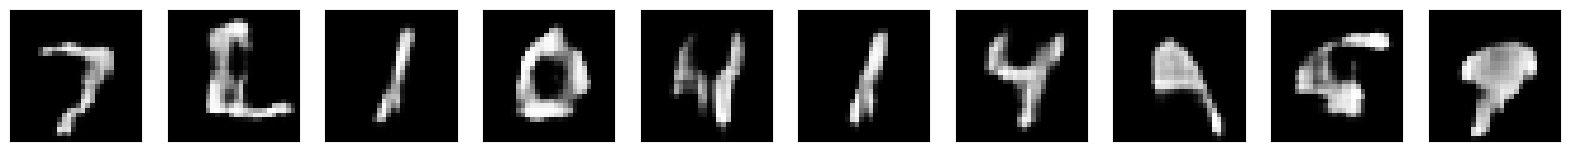

In [90]:
import matplotlib.pyplot as plt

x_test_pred_mnist = conv_autoencoder.predict(x_test_MNIST.reshape((10000, 28, 28, 1)))

n = 10

print("Original")
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_MNIST[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Reconstruido")
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_pred_mnist[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

BASTANTE bien eh? son números con una onda ropística...
Algo interesante seria hacer un autoencoder para MNIST y después pasarle la ropa...

In [92]:
from sklearn.metrics import mean_squared_error

error_reconstruccion_MNIST = mean_squared_error(x_test_MNIST.flatten(), x_test_pred_mnist.flatten())
error_reconstruccion_FMNIST = mean_squared_error(X_test.flatten(), x_test_pred_FASHION.flatten())

un_error_mnist = mean_squared_error(x_test_MNIST[0].flatten(), x_test_pred_mnist[0].flatten())
un_error_fmnist = mean_squared_error(X_test[0].flatten(), x_test_pred_FASHION[0].flatten())

print("Error de reconstrucción (MSE) MNIST:", error_reconstruccion_MNIST)
print("Error de reconstrucción (MSE) FASHION-MNIST:", error_reconstruccion_FMNIST)

print("Error de reconstrucción (MSE) un elemento de MNIST:", un_error_mnist)
print("Error de reconstrucción (MSE) un elemento de FASHION-MNIST:", un_error_fmnist)

Error de reconstrucción (MSE) MNIST: 0.02760319
Error de reconstrucción (MSE) FASHION-MNIST: 0.010352354397985595
Error de reconstrucción (MSE) un elemento de MNIST: 0.019585464
Error de reconstrucción (MSE) un elemento de FASHION-MNIST: 0.0037066912801865504


¿A que apunta esto? a que los elementos "extraños" van a tener un error de reproducción mayor, acá es un caso extremo donde se está tratando de reconstruir algo de otro dominio, pero una prenda "rara" tendria un error mayor que una ropa "normal", se puede analizar el error de todo el conjunto de test de fashion MNIST, ver en que zona se mueve el error considerado normal y definir un umbral, cualquier cosa con un error de reproducción mayor se puede considerar una anomalia y analizarse en detalle.

También se podría tratar de buscar estas anomalias en el espacio latente, pero vimos que acá no tiene mucho sentido, eso se los dejamos a los variacionales...